## Lasso & PDS 

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from sklearn.preprocessing import RobustScaler
from sklearn.base import TransformerMixin
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from numpy.linalg import inv
from statsmodels.iolib.summary2 import summary_col
from sklearn import metrics

## 1. Data

### 1.1 Read data set

In [2]:
df = pd.read_csv("Melbourne_housing_FULL.csv")

In [3]:
# Show the first few rows of the data
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


In [4]:
df = df.rename(columns={"Lattitude": "Latitude", 'Longtitude': 'Longitude'})

In [5]:
# View information on columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         34857 non-null  object 
 1   Address        34857 non-null  object 
 2   Rooms          34857 non-null  int64  
 3   Type           34857 non-null  object 
 4   Price          27247 non-null  float64
 5   Method         34857 non-null  object 
 6   SellerG        34857 non-null  object 
 7   Date           34857 non-null  object 
 8   Distance       34856 non-null  float64
 9   Postcode       34856 non-null  float64
 10  Bedroom2       26640 non-null  float64
 11  Bathroom       26631 non-null  float64
 12  Car            26129 non-null  float64
 13  Landsize       23047 non-null  float64
 14  BuildingArea   13742 non-null  float64
 15  YearBuilt      15551 non-null  float64
 16  CouncilArea    34854 non-null  object 
 17  Latitude       26881 non-null  float64
 18  Longit

### 1.1 Preprocessing

In [6]:
# drop columns
df = df.drop(['Address', "Car",'Bedroom2', "Distance",
         'Suburb', 'Postcode', 'SellerG', "BuildingArea",
         'Method', "Type", "Date", "Landsize",
        "Bathroom", "YearBuilt", "Regionname", 
        "Propertycount"], axis=1)

In [7]:
# log price
df["Price"] = np.log1p(df["Price"])

Text(0.0, 1.0, 'Price by Location')

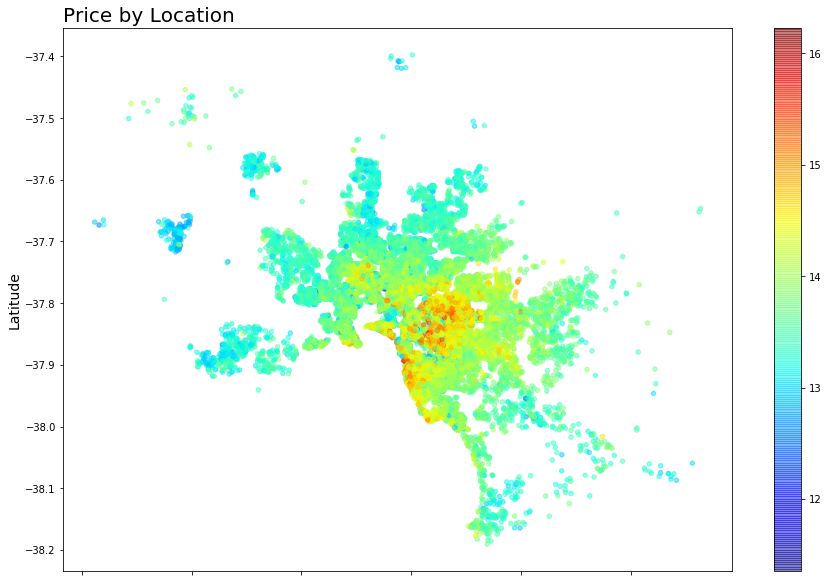

In [8]:
# plot map with price
df.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.5,
c=df.Price, cmap=plt.get_cmap("jet"), figsize=(15,10)) 
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
title = "Price by Location"
plt.title(title, loc='left', fontsize=20)

In [9]:
# normalise latitude & longitude
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[["Latitude", "Longitude"]] = scaler.fit_transform(df[["Latitude", "Longitude"]])

In [10]:
# drop NAN
df = df.dropna(how='any', subset=['Price'])
df=df.dropna(how='any', subset=['Latitude'])
df=df.dropna(how='any', subset=['Longitude'])

In [11]:
# get dummies
df = pd.get_dummies(df, columns = ["CouncilArea"])

In [12]:
list(df.columns)

['Rooms',
 'Price',
 'Latitude',
 'Longitude',
 'CouncilArea_Banyule City Council',
 'CouncilArea_Bayside City Council',
 'CouncilArea_Boroondara City Council',
 'CouncilArea_Brimbank City Council',
 'CouncilArea_Cardinia Shire Council',
 'CouncilArea_Casey City Council',
 'CouncilArea_Darebin City Council',
 'CouncilArea_Frankston City Council',
 'CouncilArea_Glen Eira City Council',
 'CouncilArea_Greater Dandenong City Council',
 'CouncilArea_Hobsons Bay City Council',
 'CouncilArea_Hume City Council',
 'CouncilArea_Kingston City Council',
 'CouncilArea_Knox City Council',
 'CouncilArea_Macedon Ranges Shire Council',
 'CouncilArea_Manningham City Council',
 'CouncilArea_Maribyrnong City Council',
 'CouncilArea_Maroondah City Council',
 'CouncilArea_Melbourne City Council',
 'CouncilArea_Melton City Council',
 'CouncilArea_Mitchell Shire Council',
 'CouncilArea_Monash City Council',
 'CouncilArea_Moonee Valley City Council',
 'CouncilArea_Moorabool Shire Council',
 'CouncilArea_Morela

In [13]:
# rearrange columns 
df = df[['Price',
 'Rooms',
 'Latitude',
 'Longitude',
 'CouncilArea_Banyule City Council',
 'CouncilArea_Bayside City Council',
 'CouncilArea_Boroondara City Council',
 'CouncilArea_Brimbank City Council',
 'CouncilArea_Cardinia Shire Council',
 'CouncilArea_Casey City Council',
 'CouncilArea_Darebin City Council',
 'CouncilArea_Frankston City Council',
 'CouncilArea_Glen Eira City Council',
 'CouncilArea_Greater Dandenong City Council',
 'CouncilArea_Hobsons Bay City Council',
 'CouncilArea_Hume City Council',
 'CouncilArea_Kingston City Council',
 'CouncilArea_Knox City Council',
 'CouncilArea_Macedon Ranges Shire Council',
 'CouncilArea_Manningham City Council',
 'CouncilArea_Maribyrnong City Council',
 'CouncilArea_Maroondah City Council',
 'CouncilArea_Melbourne City Council',
 'CouncilArea_Melton City Council',
 'CouncilArea_Mitchell Shire Council',
 'CouncilArea_Monash City Council',
 'CouncilArea_Moonee Valley City Council',
 'CouncilArea_Moorabool Shire Council',
 'CouncilArea_Moreland City Council',
 'CouncilArea_Nillumbik Shire Council',
 'CouncilArea_Port Phillip City Council',
 'CouncilArea_Stonnington City Council',
 'CouncilArea_Whitehorse City Council',
 'CouncilArea_Whittlesea City Council',
 'CouncilArea_Wyndham City Council',
 'CouncilArea_Yarra City Council',
 'CouncilArea_Yarra Ranges Shire Council']]

In [14]:
df.isnull().sum()

Price                                         0
Rooms                                         0
Latitude                                      0
Longitude                                     0
CouncilArea_Banyule City Council              0
CouncilArea_Bayside City Council              0
CouncilArea_Boroondara City Council           0
CouncilArea_Brimbank City Council             0
CouncilArea_Cardinia Shire Council            0
CouncilArea_Casey City Council                0
CouncilArea_Darebin City Council              0
CouncilArea_Frankston City Council            0
CouncilArea_Glen Eira City Council            0
CouncilArea_Greater Dandenong City Council    0
CouncilArea_Hobsons Bay City Council          0
CouncilArea_Hume City Council                 0
CouncilArea_Kingston City Council             0
CouncilArea_Knox City Council                 0
CouncilArea_Macedon Ranges Shire Council      0
CouncilArea_Manningham City Council           0
CouncilArea_Maribyrnong City Council    

In [15]:
df.shape

(20993, 37)

### 1.2 Data analysis

Text(0.0, 1.0, 'Distribution Log Price')

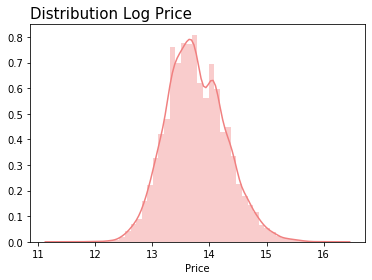

In [16]:
# plot dist prices
Prices=df['Price']
sns.distplot(Prices, color="lightcoral") 
title = "Distribution Log Price"
plt.title(title, loc='left', fontsize=15)

In [18]:
# skew & Kurt price
print('Skew: ',df['Price'].astype(float).skew())
print('Kurt: ',df['Price'].astype(float).kurt())

Skew:  0.2710092784765611
Kurt:  0.1032515696832279


Text(0.0, 1.0, 'Distribution No. of Rooms')

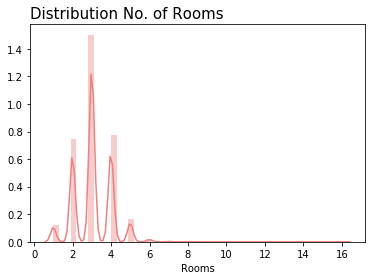

In [17]:
# plot dist rooms
Room=df['Rooms']
sns.distplot(Room, color = "lightcoral") 
title = "Distribution No. of Rooms"
plt.title(title, loc='left', fontsize=15)

In [19]:
df["Rooms"].describe()

count    20993.000000
mean         3.059163
std          0.949881
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         16.000000
Name: Rooms, dtype: float64

Text(0.0, 1.0, 'Scatter Plot')

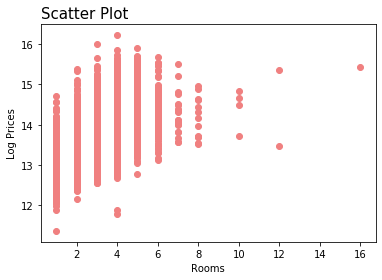

In [20]:
# scatter plot Rooms & log prices
plt.scatter('Rooms', 'Price', data=df, color="lightcoral")
plt.show
title = "Scatter Plot"
plt.xlabel("Rooms")
plt.ylabel("Log Prices")
plt.title(title, loc='left', fontsize=15)

In [ ]:
# plot correlation matrix
plt.figure(figsize=(30,20))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
corrMap = sns.heatmap(df.corr(),annot=True,mask=mask,cmap="RdPu")
corrMap.set_xticklabels(corrMap.get_xticklabels(), rotation = 75)
title = "Correlation Matrix"
plt.title(title, loc='left', fontsize=24)
plt.show()

In [ ]:
# impute median 
#from sklearn.impute import SimpleImputer
#imp = SimpleImputer(missing_values=np.NaN, strategy="median")
#df["Car"] = imp.fit_transform(df[["Car"]]).ravel()
#df["BuildingArea"] = imp.fit_transform(df[["BuildingArea"]]).ravel()
#df["Landsize"] = imp.fit_transform(df[["Landsize"]]).ravel()


## 2. Inference  OLS & PDS

### 2.1 OLS 

In [21]:
# Add constant term to the dataset -> for OLS, we need a constant to not make our model biased

df['const'] = 1

In [22]:
# Create lists of variables to be used in each regression
XRo = df[["const","Rooms"]]
XRo2 = df[["const", "Rooms", 'Latitude', 'Longitude']]
XRo3 = df[["const",'Rooms', 'Latitude', 'Longitude', 'CouncilArea_Banyule City Council', 'CouncilArea_Bayside City Council', 'CouncilArea_Boroondara City Council', 'CouncilArea_Brimbank City Council', 'CouncilArea_Cardinia Shire Council', 'CouncilArea_Casey City Council', 'CouncilArea_Darebin City Council', 'CouncilArea_Frankston City Council', 'CouncilArea_Glen Eira City Council', 'CouncilArea_Greater Dandenong City Council', 'CouncilArea_Hobsons Bay City Council', 'CouncilArea_Hume City Council', 'CouncilArea_Kingston City Council', 'CouncilArea_Knox City Council', 'CouncilArea_Macedon Ranges Shire Council', 'CouncilArea_Manningham City Council', 'CouncilArea_Maribyrnong City Council', 'CouncilArea_Maroondah City Council', 'CouncilArea_Melbourne City Council', 'CouncilArea_Melton City Council', 'CouncilArea_Mitchell Shire Council', 'CouncilArea_Monash City Council', 'CouncilArea_Moonee Valley City Council', 'CouncilArea_Moorabool Shire Council', 'CouncilArea_Moreland City Council', 'CouncilArea_Nillumbik Shire Council', 'CouncilArea_Port Phillip City Council', 'CouncilArea_Stonnington City Council', 'CouncilArea_Whitehorse City Council', 'CouncilArea_Whittlesea City Council', 'CouncilArea_Wyndham City Council', 'CouncilArea_Yarra City Council']]
y = df['Price']

# Estimate an OLS regression for each set of variables
regRo = sm.OLS(y, XRo).fit()
regRo2 = sm.OLS(y, XRo2).fit()
regRo3 = sm.OLS(y, XRo3).fit()

In [23]:
# summary OLS
info_dict={'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[regRo,regRo2,regRo3],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['Model 1','Model 2','Model 3'],
                            info_dict=info_dict,
                            regressor_order=['const',"Rooms",'Latitude','Latitude2'])

results_table

,Model 1,Model 2,Model 3
const,12.9321***,13.0344***,13.2394***
,(0.0104),(0.0242),(0.1012)
Rooms,0.2711***,0.2667***,0.3205***
,(0.0033),(0.0031),(0.0026)
Latitude,,-0.9029***,-1.6276***
,,(0.0273),(0.0767)
CouncilArea_Banyule City Council,,,0.3601***
,,,(0.0489)
CouncilArea_Bayside City Council,,,0.4287***
,,,(0.0555)


### 2.2 PDS 

In [24]:
# Variables

X = df["Rooms"]
Z = df[['Latitude', 'Longitude', 'CouncilArea_Banyule City Council', 'CouncilArea_Bayside City Council', 'CouncilArea_Boroondara City Council', 'CouncilArea_Brimbank City Council', 'CouncilArea_Cardinia Shire Council', 'CouncilArea_Casey City Council', 'CouncilArea_Darebin City Council', 'CouncilArea_Frankston City Council', 'CouncilArea_Glen Eira City Council', 'CouncilArea_Greater Dandenong City Council', 'CouncilArea_Hobsons Bay City Council', 'CouncilArea_Hume City Council', 'CouncilArea_Kingston City Council', 'CouncilArea_Knox City Council', 'CouncilArea_Macedon Ranges Shire Council', 'CouncilArea_Manningham City Council', 'CouncilArea_Maribyrnong City Council', 'CouncilArea_Maroondah City Council', 'CouncilArea_Melbourne City Council', 'CouncilArea_Melton City Council', 'CouncilArea_Mitchell Shire Council', 'CouncilArea_Monash City Council', 'CouncilArea_Moonee Valley City Council', 'CouncilArea_Moorabool Shire Council', 'CouncilArea_Moreland City Council', 'CouncilArea_Nillumbik Shire Council', 'CouncilArea_Port Phillip City Council', 'CouncilArea_Stonnington City Council', 'CouncilArea_Whitehorse City Council', 'CouncilArea_Whittlesea City Council', 'CouncilArea_Wyndham City Council', 'CouncilArea_Yarra City Council','CouncilArea_Yarra Ranges Shire Council']]
y = df["Price"]

In [25]:
columnsDF = list(Z.columns)
columnsDF = pd.DataFrame(columnsDF)
columnsDF

,0
0,Latitude
1,Longitude
2,CouncilArea_Banyule City Council
3,CouncilArea_Bayside City Council
4,CouncilArea_Boroondara City Council
5,CouncilArea_Brimbank City Council
6,CouncilArea_Cardinia Shire Council
7,CouncilArea_Casey City Council
8,CouncilArea_Darebin City Council
9,CouncilArea_Frankston City Council


#### 2.2.1 double lasso selection 

In [ ]:
# First Stage Selection 
# regress X on Z 
FsLassoReg1 = Lasso(alpha= 0.0005)
FsLassoReg1.fit(Z,X)

FsLassoReg2 = Lasso(alpha= 0.001)
FsLassoReg2.fit(Z,X)

FsLassoReg3 = Lasso(alpha= 0.005)
FsLassoReg3.fit(Z,X)

FsLassoReg4 = Lasso(alpha= 0.01)
FsLassoReg4.fit(Z,X)


In [ ]:
# Reduced Form Selection
# regress y on Z 
RfLassoReg1 = Lasso(alpha= 0.0005)
RfLassoReg1.fit(Z,y)

RfLassoReg2 = Lasso(alpha= 0.001)
RfLassoReg2.fit(Z,y)

RfLassoReg3 = Lasso(alpha= 0.005)
RfLassoReg3.fit(Z,y)

RfLassoReg4 = Lasso(alpha= 0.01)
RfLassoReg4.fit(Z,y)

In [ ]:
# create data frame with coefficients 1
FsCoef1 =FsLassoReg1.coef_
RfCoef1 = RfLassoReg1.coef_
# create data frame
df1 = pd.DataFrame(data=[FsCoef1, RfCoef1])
df1 = df1.T
df1 = df1.rename(columns={0:"Fs1", 1:"Rs1"})

In [ ]:
# create data frame with coefficients 2
FsCoef2 = FsLassoReg2.coef_
RfCoef2 = RfLassoReg2.coef_
# create data frame
df2 = pd.DataFrame(data=[FsCoef2, RfCoef2])
df2 = df2.T
df2 = df2.rename(columns={0:"Fs2", 1:"Rs2"})

In [ ]:
# create data frame with coefficients 3
FsCoef3 =FsLassoReg3.coef_
RfCoef3 = RfLassoReg3.coef_
# create data frame
df3 = pd.DataFrame(data=[FsCoef3, RfCoef3])
df3 = df3.T
df3 = df3.rename(columns={0:"Fs3", 1:"Rs3"})

In [ ]:
# create data frame with coefficients 4
FsCoef4 =FsLassoReg4.coef_
RfCoef4 = RfLassoReg4.coef_
# create data frame
df4 = pd.DataFrame(data=[FsCoef4, RfCoef4])
df4 = df4.T
df4 = df4.rename(columns={0:"Fs4", 1:"Rs4"})

In [ ]:
# combine all data frames of selection Process
PDSResults = pd.concat([df1, df2, df3, df4], axis=1)
PDSResults.index=['Latitude', 'Longitude', 'CouncilArea_Banyule City Council', 'CouncilArea_Bayside City Council', 'CouncilArea_Boroondara City Council', 'CouncilArea_Brimbank City Council', 'CouncilArea_Cardinia Shire Council', 'CouncilArea_Casey City Council', 'CouncilArea_Darebin City Council', 'CouncilArea_Frankston City Council', 'CouncilArea_Glen Eira City Council', 'CouncilArea_Greater Dandenong City Council', 'CouncilArea_Hobsons Bay City Council', 'CouncilArea_Hume City Council', 'CouncilArea_Kingston City Council', 'CouncilArea_Knox City Council', 'CouncilArea_Macedon Ranges Shire Council', 'CouncilArea_Manningham City Council', 'CouncilArea_Maribyrnong City Council', 'CouncilArea_Maroondah City Council', 'CouncilArea_Melbourne City Council', 'CouncilArea_Melton City Council', 'CouncilArea_Mitchell Shire Council', 'CouncilArea_Monash City Council', 'CouncilArea_Moonee Valley City Council', 'CouncilArea_Moorabool Shire Council', 'CouncilArea_Moreland City Council', 'CouncilArea_Nillumbik Shire Council', 'CouncilArea_Port Phillip City Council', 'CouncilArea_Stonnington City Council', 'CouncilArea_Whitehorse City Council', 'CouncilArea_Whittlesea City Council', 'CouncilArea_Wyndham City Council', 'CouncilArea_Yarra City Council','CouncilArea_Yarra Ranges Shire Council']
PDSResults

In [ ]:
# choose coefficients 
### Z1
Z1 = df.drop(["Price", "CouncilArea_Macedon Ranges Shire Council", "CouncilArea_Maroondah City Council", 
"CouncilArea_Mitchell Shire Council", "CouncilArea_Nillumbik Shire Council",
"CouncilArea_Yarra Ranges Shire Council"], axis=1)

### Z2
Z2 = df.drop(["Price", "CouncilArea_Cardinia Shire Council","CouncilArea_Macedon Ranges Shire Council",
            "CouncilArea_Maroondah City Council","CouncilArea_Mitchell Shire Council",
            "CouncilArea_Moorabool Shire Council","CouncilArea_Yarra Ranges Shire Council"], axis=1)

### Z3
Z3 = df.drop(["Price", "Latitude", "CouncilArea_Banyule City Council",  "CouncilArea_Cardinia Shire Council",  
             "CouncilArea_Casey City Council",  "CouncilArea_Frankston City Council",  
             "CouncilArea_Greater Dandenong City Council",  "CouncilArea_Hobsons Bay City Council",  
             "CouncilArea_Kingston City Council",  "CouncilArea_Knox City Council",  
             "CouncilArea_Macedon Ranges Shire Council",  "CouncilArea_Maroondah City Council", 
             "CouncilArea_Mitchell Shire Council",  "CouncilArea_Moorabool Shire Council",  
             "CouncilArea_Nillumbik Shire Council",  "CouncilArea_Whitehorse City Council",  
             "CouncilArea_Yarra Ranges Shire Council"], axis=1)

### Z4
Z4 = df[["const","Rooms","Longitude", "CouncilArea_Bayside City Council", 
       "CouncilArea_Boroondara City Council", "CouncilArea_Brimbank City Council",  
       "CouncilArea_Darebin City Council", "CouncilArea_Glen Eira City Council",  
       "CouncilArea_Hobsons Bay City Council", "CouncilArea_Manningham City Council",  
       "CouncilArea_Maribyrnong City Council", "CouncilArea_Melbourne City Council",  
       "CouncilArea_Monash City Council", "CouncilArea_Moreland City Council",  
       "CouncilArea_Port Phillip City Council", "CouncilArea_Stonnington City Council",  
       "CouncilArea_Whitehorse City Council", "CouncilArea_Yarra City Council"]]


#### 2.2.2 Final Linear Regression 

In [ ]:
# Estimate an OLS regression for each set of variables
regZ1 = sm.OLS(y, Z1).fit()
regZ2 = sm.OLS(y, Z2).fit()
regZ3 = sm.OLS(y, Z3).fit()
regZ4 = sm.OLS(y, Z4).fit()

In [ ]:
# Summary of all regressions
info_dict={'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[regRo, regRo2, regRo3, regZ1,regZ2,regZ3, regZ4],
                            float_format='%0.4f',
                            stars = True,
                            model_names=["Model R1", "Model R2", "Model R3",'Model Z1','Model Z2','Model Z3', "Model Z4"],
                            info_dict=info_dict,
                            regressor_order=['const',"Rooms",'Latitude','Longitude'])

results_table

# last variable misssing due to OLS (dummy trap)

In [ ]:
#print("Adjusted R^2 for Simple Regression:", regRo.rsquared_adj)
#print("Adjusted R^2 for Regression Lat&Long:",regRo2.rsquared_adj)
#print("Adjusted R^2 for Multiple Regression:",regRo3.rsquared_adj)
#print("-----------------")
#print("Adjusted R^2 for PDS with alpha 0.0005:",regZ1.rsquared_adj)
#print("Adjusted R^2 for PDS with alpha 0.001:",regZ2.rsquared_adj)
#print("Adjusted R^2 for PDS with alpha 0.005:",regZ3.rsquared_adj)
#print("Adjusted R^2 for PDS with alpha 0.01:",regZ4.rsquared_adj)